In [5]:
import pandas as pd
import numpy as np
import re
import string
from pathlib import Path

In [6]:
# Visualization
import matplotlib.pyplot as plt

In [7]:
# ML & NLP
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report, confusion_matrix, roc_auc_score, roc_curve

In [15]:
# Ensure inline plotting
# (For Jupyter) - If running in some environments, this isn't necessary, but it's okay to include.
%matplotlib inline

# Load dataset
csv_path = '/mnt/data/spam_dataset.csv'  # Update path if neede

df.head(10)

,label,message
0,spam,Win a FREE iPhone now by clicking this link!
1,ham,"Hey, are we still meeting for lunch tomorrow?"
2,spam,Congratulations! You have won a lottery of $50...
3,ham,Can you send me the notes from yesterday’s class?
4,spam,"Exclusive offer just for you, limited time dis..."
5,ham,I will call you once I reach home.
6,spam,"You have been selected for a cash prize, reply..."
7,ham,Don’t forget to complete the assignment by ton...
8,spam,"Lowest prices on medicines, order now from our..."
9,ham,Happy Birthday! Wishing you a great year ahead.


In [16]:
# Basic info
display(df.sample(5))
print('\nShape:', df.shape)
print('\nColumns:', df.columns.tolist())
print('\nNulls:\n', df.isna().sum())

,label,message
47,ham,Let’s meet at the cafe after the lecture.
38,spam,Congratulations! You have been shortlisted for...
9,ham,Happy Birthday! Wishing you a great year ahead.
36,spam,Lowest insurance rates guaranteed! Check now.
35,ham,My mom asked if you could come over for dinner.



Shape: (50, 2)

Columns: ['label', 'message']

Nulls:
 label      0
message    0
dtype: int64


In [17]:
# Class distribution
counts = df['label'].value_counts()
print('\nClass distribution:\n', counts)


Class distribution:
 label
spam    25
ham     25
Name: count, dtype: int64


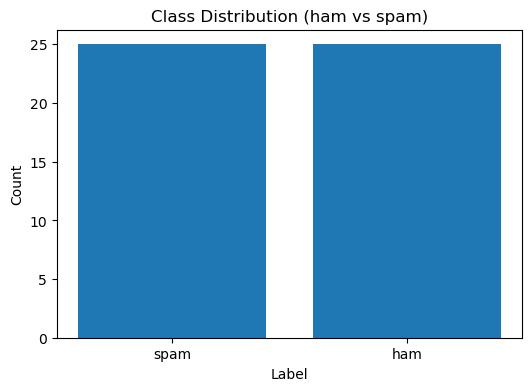

In [18]:
# Plot class distribution
plt.figure(figsize=(6,4))
plt.bar(counts.index, counts.values)
plt.title('Class Distribution (ham vs spam)')
plt.xlabel('Label')
plt.ylabel('Count')
plt.show()

In [19]:
# Message length analysis
df['msg_len'] = df['message'].str.len()
print('\nMessage length (summary):\n', df['msg_len'].describe())


Message length (summary):
 count    50.000000
mean     47.260000
std       6.898122
min      31.000000
25%      43.250000
50%      46.500000
75%      52.000000
max      60.000000
Name: msg_len, dtype: float64


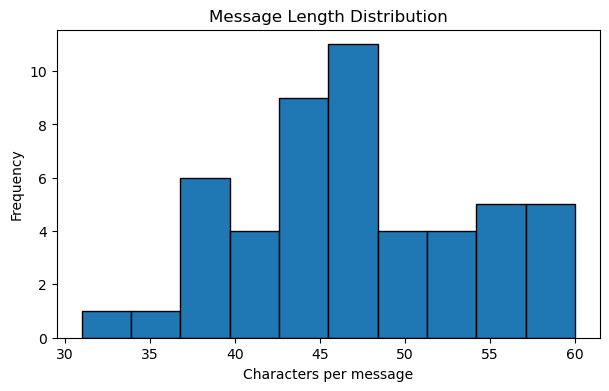

In [20]:
plt.figure(figsize=(7,4))
plt.hist(df['msg_len'], bins=10, edgecolor='black')
plt.title('Message Length Distribution')
plt.xlabel('Characters per message')
plt.ylabel('Frequency')
plt.show()

In [21]:
# Simple top tokens (quick & light) - lowercase split on non-letters
def tokenize_simple(text):
    return re.findall(r"[a-z']+", text.lower())

from collections import Counter
spam_tokens = Counter()
ham_tokens = Counter()

for _, row in df.iterrows():
    toks = tokenize_simple(row['message'])
    if row['label'] == 'spam':
        spam_tokens.update(toks)
    else:
        ham_tokens.update(toks)

print('\nTop 10 tokens in spam:', spam_tokens.most_common(10))
print('Top 10 tokens in ham:', ham_tokens.most_common(10))


Top 10 tokens in spam: [('you', 8), ('now', 7), ('a', 6), ('your', 6), ('free', 5), ('get', 5), ('have', 4), ('claim', 4), ('for', 4), ('our', 4)]
Top 10 tokens in ham: [('the', 18), ('you', 14), ('i', 7), ('to', 6), ('for', 5), ('s', 5), ('are', 4), ('tomorrow', 4), ('can', 4), ('class', 4)]


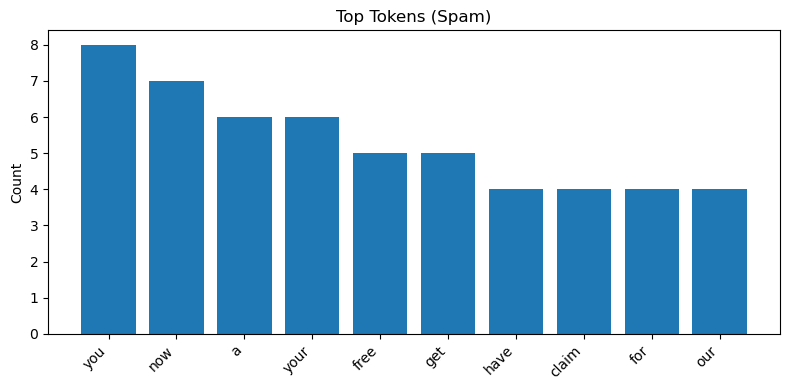

In [22]:
# Plot top spam tokens
top_spam = spam_tokens.most_common(10)
if top_spam:
    labels_s, values_s = zip(*top_spam)
    plt.figure(figsize=(8,4))
    plt.bar(range(len(values_s)), values_s)
    plt.xticks(range(len(labels_s)), labels_s, rotation=45, ha='right')
    plt.title('Top Tokens (Spam)')
    plt.ylabel('Count')
    plt.tight_layout()
    plt.show()

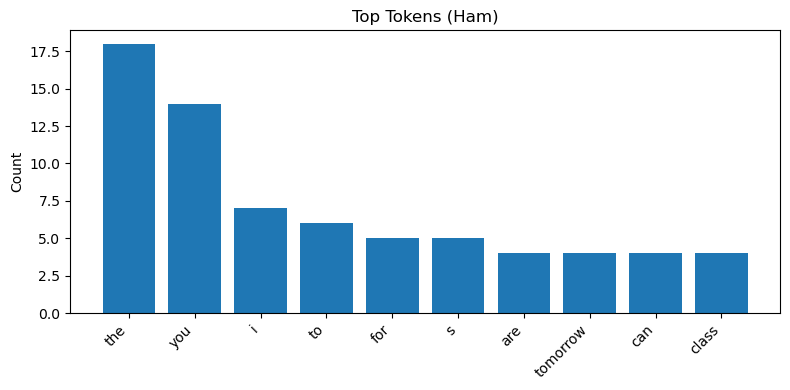

In [23]:
# Plot top ham tokens
top_ham = ham_tokens.most_common(10)
if top_ham:
    labels_h, values_h = zip(*top_ham)
    plt.figure(figsize=(8,4))
    plt.bar(range(len(values_h)), values_h)
    plt.xticks(range(len(labels_h)), labels_h, rotation=45, ha='right')
    plt.title('Top Tokens (Ham)')
    plt.ylabel('Count')
    plt.tight_layout()
    plt.show()


In [24]:
# We'll implement a lightweight cleaner.
# (Lowercase, remove URLs, digits, punctuation; keep simple to avoid heavy dependencies)

URL_PATTERN = re.compile(r'https?://\S+|www\.\S+')
HTML_PATTERN = re.compile(r'<.*?>')

def clean_text(s: str) -> str:
    s = s.lower()
    s = re.sub(URL_PATTERN, ' ', s)
    s = re.sub(HTML_PATTERN, ' ', s)
    s = re.sub(r'\d+', ' ', s)
    s = s.translate(str.maketrans('', '', string.punctuation))
    s = re.sub(r'\s+', ' ', s).strip()
    return s

df['message_clean'] = df['message'].astype(str).apply(clean_text)

display(df[['label','message','message_clean']].head(10))

,label,message,message_clean
0,spam,Win a FREE iPhone now by clicking this link!,win a free iphone now by clicking this link
1,ham,"Hey, are we still meeting for lunch tomorrow?",hey are we still meeting for lunch tomorrow
2,spam,Congratulations! You have won a lottery of $50...,congratulations you have won a lottery of clai...
3,ham,Can you send me the notes from yesterday’s class?,can you send me the notes from yesterday’s class
4,spam,"Exclusive offer just for you, limited time dis...",exclusive offer just for you limited time disc...
5,ham,I will call you once I reach home.,i will call you once i reach home
6,spam,"You have been selected for a cash prize, reply...",you have been selected for a cash prize reply ...
7,ham,Don’t forget to complete the assignment by ton...,don’t forget to complete the assignment by ton...
8,spam,"Lowest prices on medicines, order now from our...",lowest prices on medicines order now from our ...
9,ham,Happy Birthday! Wishing you a great year ahead.,happy birthday wishing you a great year ahead


In [25]:
X_text = df['message_clean'].values
y = (df['label'].values == 'spam').astype(int)  # spam -> 1, ham -> 0

X_train_text, X_test_text, y_train, y_test = train_test_split(
    X_text, y, test_size=0.2, random_state=42, stratify=y
)

# TF-IDF vectorizer
tfidf = TfidfVectorizer(stop_words='english', ngram_range=(1,2), min_df=1)
X_train = tfidf.fit_transform(X_train_text)
X_test = tfidf.transform(X_test_text)

print('Train shape:', X_train.shape, '| Test shape:', X_test.shape)

Train shape: (40, 283) | Test shape: (10, 283)


In [26]:
models = {
    'NaiveBayes': MultinomialNB(),
    'LogisticRegression': LogisticRegression(max_iter=1000),
    'RandomForest': RandomForestClassifier(n_estimators=200, random_state=42)
}

fitted = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    fitted[name] = model
    print(f'{name} trained.')

NaiveBayes trained.
LogisticRegression trained.
RandomForest trained.



=== NaiveBayes ===
Accuracy (train): 1.000 | Accuracy (test): 1.000

Classification report (test):
               precision    recall  f1-score   support

         ham       1.00      1.00      1.00         5
        spam       1.00      1.00      1.00         5

    accuracy                           1.00        10
   macro avg       1.00      1.00      1.00        10
weighted avg       1.00      1.00      1.00        10

Confusion matrix (test):
 [[5 0]
 [0 5]]


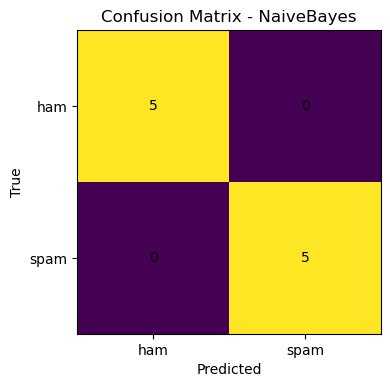

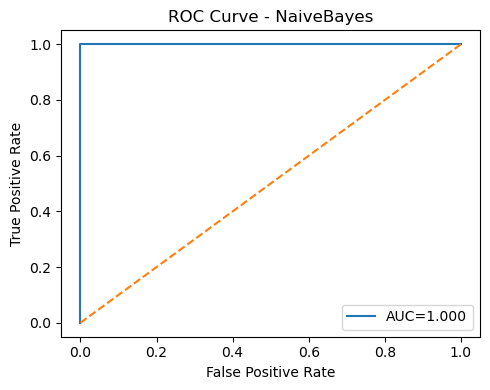


=== LogisticRegression ===
Accuracy (train): 1.000 | Accuracy (test): 0.900

Classification report (test):
               precision    recall  f1-score   support

         ham       1.00      0.80      0.89         5
        spam       0.83      1.00      0.91         5

    accuracy                           0.90        10
   macro avg       0.92      0.90      0.90        10
weighted avg       0.92      0.90      0.90        10

Confusion matrix (test):
 [[4 1]
 [0 5]]


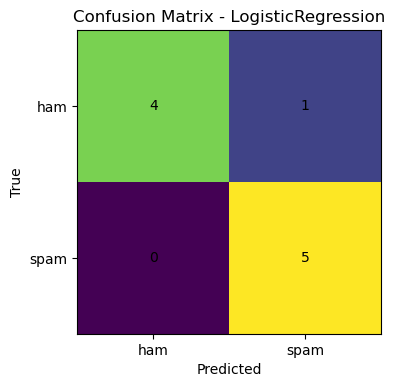

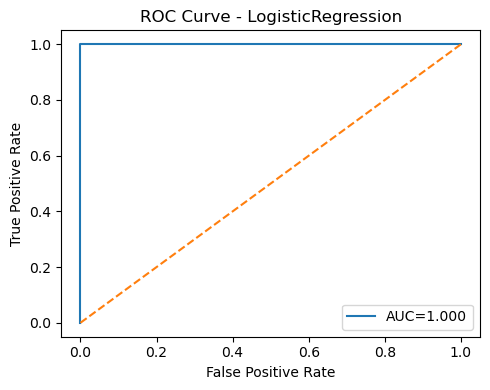


=== RandomForest ===
Accuracy (train): 1.000 | Accuracy (test): 0.700

Classification report (test):
               precision    recall  f1-score   support

         ham       0.62      1.00      0.77         5
        spam       1.00      0.40      0.57         5

    accuracy                           0.70        10
   macro avg       0.81      0.70      0.67        10
weighted avg       0.81      0.70      0.67        10

Confusion matrix (test):
 [[5 0]
 [3 2]]


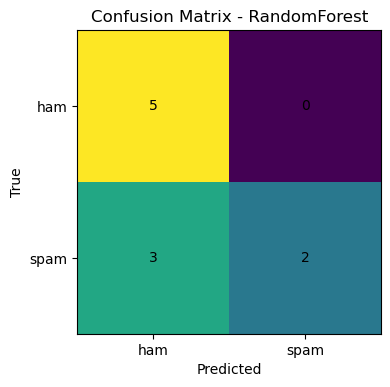

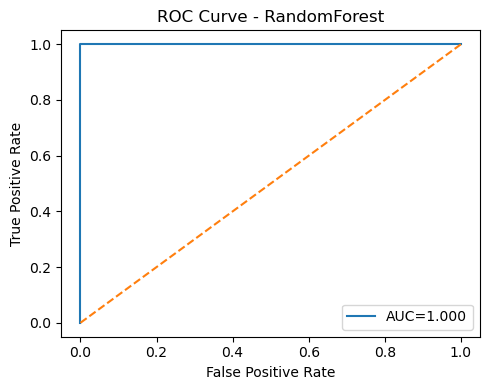


Test Accuracies: {'NaiveBayes': 1.0, 'LogisticRegression': 0.9, 'RandomForest': 0.7}


In [27]:
def evaluate_model(name, model, X_tr, y_tr, X_te, y_te):
    y_pred_tr = model.predict(X_tr)
    y_pred_te = model.predict(X_te)
    
    acc_tr = accuracy_score(y_tr, y_pred_tr)
    acc_te = accuracy_score(y_te, y_pred_te)
    
    print(f'\n=== {name} ===')
    print(f'Accuracy (train): {acc_tr:.3f} | Accuracy (test): {acc_te:.3f}')
    print('\nClassification report (test):\n', classification_report(y_te, y_pred_te, target_names=['ham','spam']))
    
    # Confusion matrix (test)
    cm = confusion_matrix(y_te, y_pred_te)
    print('Confusion matrix (test):\n', cm)
    
    # Plot confusion matrix with matplotlib only
    plt.figure(figsize=(4,4))
    plt.imshow(cm, interpolation='nearest')
    plt.title(f'Confusion Matrix - {name}')
    plt.xticks([0,1], ['ham','spam'])
    plt.yticks([0,1], ['ham','spam'])
    for (i, j), z in np.ndenumerate(cm):
        plt.text(j, i, str(z), ha='center', va='center')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.tight_layout()
    plt.show()
    
    # ROC curve (if proba available)
    if hasattr(model, 'predict_proba'):
        y_proba = model.predict_proba(X_te)[:,1]
        fpr, tpr, thr = roc_curve(y_te, y_proba)
        auc = roc_auc_score(y_te, y_proba)
        plt.figure(figsize=(5,4))
        plt.plot(fpr, tpr, label=f'AUC={auc:.3f}')
        plt.plot([0,1],[0,1],'--')
        plt.title(f'ROC Curve - {name}')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.legend()
        plt.tight_layout()
        plt.show()
    return acc_te

results = {}
for name, model in fitted.items():
    results[name] = evaluate_model(name, model, X_train, y_train, X_test, y_test)

print('\nTest Accuracies:', results)

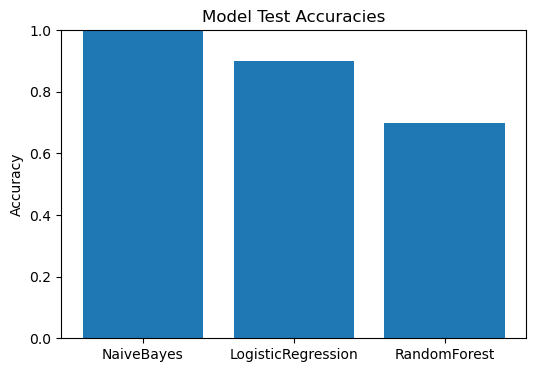

In [28]:
# Bar chart of test accuracies
names = list(results.keys())
scores = [results[n] for n in names]

plt.figure(figsize=(6,4))
plt.bar(names, scores)
plt.title('Model Test Accuracies')
plt.ylabel('Accuracy')
plt.ylim(0,1)
plt.show()

In [29]:
# Inspect top weighted features for Logistic Regression (if linear)
def show_top_features_lr(model, vectorizer, n=15):
    if not hasattr(model, 'coef_'):
        print('No coefficients to display.')
        return
    feature_names = np.array(vectorizer.get_feature_names_out())
    coefs = model.coef_[0]
    top_spam_idx = np.argsort(coefs)[-n:][::-1]
    top_ham_idx = np.argsort(coefs)[:n]
    print('\nTop features indicating SPAM:')
    for i in top_spam_idx:
        print(f'{feature_names[i]} : {coefs[i]:.3f}')
    print('\nTop features indicating HAM:')
    for i in top_ham_idx:
        print(f'{feature_names[i]} : {coefs[i]:.3f}')

print('\nLogistic Regression Top Features:')
show_top_features_lr(fitted['LogisticRegression'], tfidf, n=15)


Logistic Regression Top Features:

Top features indicating SPAM:
free : 0.468
claim : 0.323
today : 0.318
congratulations : 0.291
prize : 0.264
discounts : 0.257
sale : 0.246
lowest : 0.242
won : 0.240
hurry : 0.235
exclusive : 0.225
win : 0.223
offer : 0.222
just : 0.213
cash : 0.211

Top features indicating HAM:
class : -0.438
tomorrow : -0.394
weekend : -0.341
forget : -0.314
don forget : -0.314
don : -0.314
evening : -0.291
ll : -0.291
assignment : -0.274
let : -0.268
yesterday : -0.252
reach home : -0.247
reach : -0.247
trip : -0.232
trip weekend : -0.232
